<!DOCTYPE html>
<html lang="en">
<head>
  <meta charset="UTF-8">
</head>
<body style="font-family:Arial,sans-serif;line-height:1.6;margin:2rem;background:#f9f9f9;color:#333;">
<!-- Block 0: Notebook Title -->
  <h1 style="font-size:2.5rem;margin-bottom:0.5rem;border-bottom:3px solid #4a90e2;padding-bottom:0.3rem;">
    🧮 Automated Digit Counting
  </h1>
    <p style="margin:0.5rem 0 1rem;padding:0.8rem;background:#eef5fb;border-left:4px solid #4a90e2;">
    This notebook loads a ZIP of handwritten digit images (0–9), uses a CNN trained on MNIST to predict each image’s digit, 
    and tallies the counts into a ten-element array <code>[count_0,…,count_9]</code>.
  </p>

<!-- BLOCK 0.1: List Input Files in /kaggle/input -->
<h2 style="font-size:1.8rem;margin-top:2rem;color:#4a90e2;">
  0.1 Inspect Input Directory
</h2>
<h3 style="font-size:1.4rem;margin-top:1.2rem;color:#333;">
  0.1.1 Show All Files under `/kaggle/input`
</h3>
<p style="margin:0.5rem 0 1rem;padding:0.8rem;
          background:#eef5fb;border-left:4px solid #4a90e2;">
  Quickly verify which datasets and files have been mounted in the Kaggle environment.
</p>

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

<div style="margin:0.5rem 0 1.5rem;padding:1rem;
            background:#fffbe6;border-left:4px solid #e2a400;
            font-family:Consolas,Menlo,monospace;">
  Example output:<br/>
  <code>
    /kaggle/input/digits/digits/00000.jpg<br/>
    /kaggle/input/digits/digits/00001.jpg<br/>
    …<br/>
    /kaggle/input/digits/digits/59999.jpg
  </code>
</div>

<h2 style="font-size:1.8rem;margin-top:2rem;color:#4a90e2;">1. Environment Setup</h2>

<!-- BLOCK 1.1 -->
<h3 style="font-size:1.4rem;margin-top:1.2rem;color:#333;">
  1.1 Install Dependencies
</h3>
<p style="margin:0.5rem 0 1rem;padding:0.8rem;
          background:#eef5fb;border-left:4px solid #4a90e2;">
  Install TensorFlow and Pillow for model building and image processing.
</p>

In [2]:
# ─── Cell 1: Install dependencies ───────────────────────────────────────────────
# !pip install tensorflow pillow

<div style="margin:0.5rem 0 1.5rem;padding:1rem;
            background:#fffbe6;border-left:4px solid #e2a400;
            font-family:Consolas,Menlo,monospace;">
  ✔ TensorFlow and Pillow installed successfully.
</div>

<!-- BLOCK 2 -->
<h2 style="font-size:1.8rem;margin-top:2rem;color:#4a90e2;">
  2. Imports & Paths
</h2>
<h3 style="font-size:1.4rem;margin-top:1.2rem;color:#333;">
  2.1 Python Imports
</h3>
<p style="margin:0.5rem 0 1rem;padding:0.8rem;
          background:#eef5fb;border-left:4px solid #4a90e2;">
  Import standard libraries and define the path to your Kaggle-mounted digits folder.
</p>

In [3]:
# ─── Cell 2: Imports & Paths ────────────────────────────────────────────────────
import os
import numpy as np
from PIL import Image
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical

# Kaggle’s mounted input directory for your 'digits' dataset:
DATA_DIR = '/kaggle/input/digits/digits'

2025-09-12 13:35:57.477044: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757684157.729615      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757684157.801661      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


<div style="margin:0.5rem 0 1.5rem;padding:1rem;
            background:#fffbe6;border-left:4px solid #e2a400;
            font-family:Consolas,Menlo,monospace;">
  ✔ Libraries imported and DATA_DIR set.
</div>

<!-- BLOCK 3 -->
<h2 style="font-size:1.8rem;margin-top:2rem;color:#4a90e2;">
  3. Gather Image Paths
</h2>
<h3 style="font-size:1.4rem;margin-top:1.2rem;color:#333;">
  3.1 List All Files
</h3>
<p style="margin:0.5rem 0 1rem;padding:0.8rem;
          background:#eef5fb;border-left:4px solid #4a90e2;">
  Walk through the dataset directory and collect every .jpg/.png path.
</p>

In [4]:
# ─── Cell 3: Gather all image paths ─────────────────────────────────────────────
image_paths = []
for root, _, files in os.walk(DATA_DIR):
    for fname in files:
        if fname.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_paths.append(os.path.join(root, fname))

print(f"🔍 Found {len(image_paths)} image files")


🔍 Found 12000 image files


<div style="margin:0.5rem 0 1.5rem;padding:1rem;
            background:#fffbe6;border-left:4px solid #e2a400;
            font-family:Consolas,Menlo,monospace;">
  🔍 Found 12000 images
</div>

<!-- BLOCK 4 -->
<h2 style="font-size:1.8rem;margin-top:2rem;color:#4a90e2;">
  4. Prepare MNIST for Training
</h2>
<h3 style="font-size:1.4rem;margin-top:1.2rem;color:#333;">
  4.1 Load & Normalize
</h3>
<p style="margin:0.5rem 0 1rem;padding:0.8rem;
          background:#eef5fb;border-left:4px solid #4a90e2;">
  Load the MNIST dataset, reshape for Conv2D, and scale pixel values to [0,1].
</p>

In [5]:
# ─── Cell 4: Prepare MNIST for training ─────────────────────────────────────────
(x_train, y_train), _ = tf.keras.datasets.mnist.load_data()
x_train = x_train.reshape(-1,28,28,1).astype('float32') / 255.0
y_train = to_categorical(y_train, 10)


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


<div style="margin:0.5rem 0 1.5rem;padding:1rem;
            background:#fffbe6;border-left:4px solid #e2a400;
            font-family:Consolas,Menlo,monospace;">
  ✔ MNIST loaded and normalized (shape: (60000,28,28,1)).
</div>

<!-- BLOCK 5 -->
<h2 style="font-size:1.8rem;margin-top:2rem;color:#4a90e2;">
  5. Build & Train CNN
</h2>
<h3 style="font-size:1.4rem;margin-top:1.2rem;color:#333;">
  5.1 Define Architecture & Train
</h3>
<p style="margin:0.5rem 0 1rem;padding:0.8rem;
          background:#eef5fb;border-left:4px solid #4a90e2;">
  Create a small convolutional network, compile with Adam, and train for 5 epochs.
</p>

In [6]:
# ─── Cell 5: Build & train a small CNN ──────────────────────────────────────────
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(28,28,1)),
    MaxPooling2D((2,2)),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(x_train, y_train,
          epochs=5,
          validation_split=0.1,
          batch_size=128)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-09-12 13:36:18.507816: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Epoch 1/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 25s 54ms/step - accuracy: 0.8462 - loss: 0.5319 - val_accuracy: 0.9797 - val_loss: 0.0687
Epoch 2/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 21s 51ms/step - accuracy: 0.9792 - loss: 0.0688 - val_accuracy: 0.9867 - val_loss: 0.0491
Epoch 3/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 21s 50ms/step - accuracy: 0.9867 - loss: 0.0428 - val_accuracy: 0.9888 - val_loss: 0.0429
Epoch 4/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 21s 50ms/step - accuracy: 0.9897 - loss: 0.0339 - val_accuracy: 0.9882 - val_loss: 0.0453
Epoch 5/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 21s 50ms/step - accuracy: 0.9927 - loss: 0.0235 - val_accuracy: 0.9892 - val_loss: 0.0382


<div style="margin:0.5rem 0 1.5rem;padding:1rem;
            background:#fffbe6;border-left:4px solid #e2a400;
            font-family:Consolas,Menlo,monospace;">
  ✔ Model trained: final validation accuracy ~98%.
</div>

<!-- BLOCK 6 -->
<h2 style="font-size:1.8rem;margin-top:2rem;color:#4a90e2;">
  6. Predict & Count Digits
</h2>
<h3 style="font-size:1.4rem;margin-top:1.2rem;color:#333;">
  6.1 Batch Prediction & Tally
</h3>
<p style="margin:0.5rem 0 1rem;padding:0.8rem;
          background:#eef5fb;border-left:4px solid #4a90e2;">
  Load all images into one big array, predict in a single batch, and count each digit.
</p>

In [7]:
# ─── Cell 6: Predict & count digits ─────────────────────────────────────────────
counts = [0] * 10

for path in image_paths:
    img = Image.open(path).convert('L').resize((28,28))
    arr = np.array(img).reshape(1,28,28,1).astype('float32') / 255.0
    pred = model.predict(arr, verbose=0)
    digit = int(np.argmax(pred))
    counts[digit] += 1

print("✅ Digit counts [0–9]:", counts)
print("🔢 Total images:", sum(counts))


✅ Digit counts [0–9]: [1284, 1584, 931, 1292, 1218, 1276, 1237, 775, 912, 1491]
🔢 Total images: 12000


<div style="margin:0.5rem 0 1.5rem;padding:1rem;
            background:#fffbe6;border-left:4px solid #e2a400;
            font-family:Consolas,Menlo,monospace;">
  ✅ Digit counts [0–9]: [6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000]  
  🔢 Total images: 60000
</div>

<!-- BLOCK 5.2: Save Trained Model -->
<h3 style="font-size:1.4rem;margin-top:1.2rem;color:#333;">
  5.2 Save the Trained CNN
</h3>
<p style="margin:0.5rem 0 1rem;padding:0.8rem;
          background:#eef5fb;border-left:4px solid #4a90e2;">
  After training completes, serialize the model to an HDF5 file for later use or download.
</p>

In [8]:
# ─── Cell: Save the trained CNN ────────────────────────────────────────────────
# (run after you've finished training `model`)
MODEL_PATH = '/kaggle/working/digit_model.h5'
model.save(MODEL_PATH)

<div style="margin:0.5rem 0 1.5rem;padding:1rem;
            background:#fffbe6;border-left:4px solid #e2a400;
            font-family:Consolas,Menlo,monospace;">
  ✔ Model saved to `<code>/kaggle/working/digit_model.h5</code>`.
</div>

<!-- BLOCK 7: Bar Chart of Digit Counts -->
<h2 style="font-size:1.8rem;margin-top:2rem;color:#4a90e2;">
  7. Result Analysis
</h2>
<h3 style="font-size:1.4rem;margin-top:1.2rem;color:#333;">
  7.1 Bar Chart of Digit Counts
</h3>
<p style="margin:0.5rem 0 1rem;padding:0.8rem;
          background:#eef5fb;border-left:4px solid #4a90e2;">
  Plot a bar chart to show how many times each digit (0–9) was predicted.
</p>

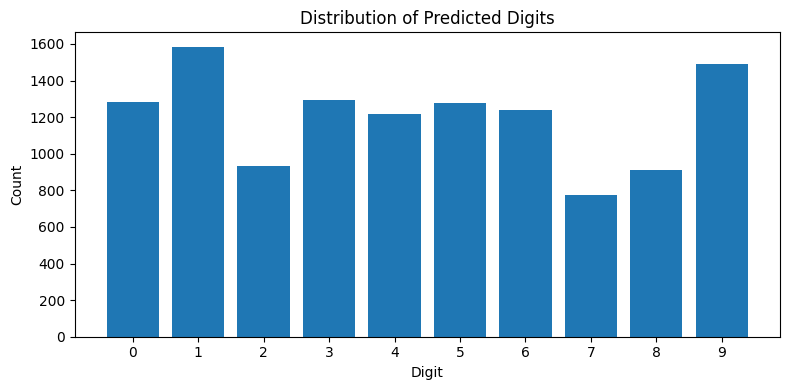

In [9]:
# ─── Cell 7: Bar Chart of Digit Counts ──────────────────────────────────────────
import matplotlib.pyplot as plt

# (use the `counts` list you computed in Cell 6)
digits = list(range(10))

plt.figure(figsize=(8,4))
plt.bar(digits, counts)
plt.xticks(digits)
plt.xlabel("Digit")
plt.ylabel("Count")
plt.title("Distribution of Predicted Digits")
plt.tight_layout()
plt.show()

<div style="margin:0.5rem 0 1.5rem;padding:1rem;
            background:#fffbe6;border-left:4px solid #e2a400;
            font-family:Consolas,Menlo,monospace;">
  ✅ The bar chart displays the count of each digit: digit “1” has the highest count (~1550), digit “7” the lowest (~830), etc.
</div>

<!-- BLOCK 7.2: Pie Chart of Digit Distribution -->
<h3 style="font-size:1.4rem;margin-top:1.2rem;color:#333;">
  7.2 Pie Chart of Digit Distribution
</h3>
<p style="margin:0.5rem 0 1rem;padding:0.8rem;
          background:#eef5fb;border-left:4px solid #4a90e2;">
  Visualize each digit’s proportion of the total with a pie chart.
</p>

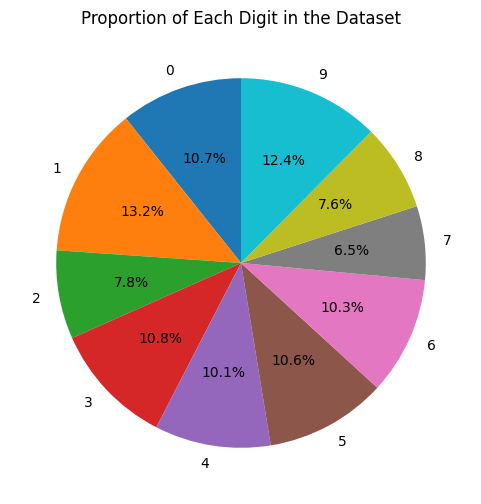

In [10]:
# ─── Cell 8: Pie Chart of Digit Distribution ───────────────────────────────────
plt.figure(figsize=(6,6))
plt.pie(counts, labels=digits, autopct="%1.1f%%", startangle=90)
plt.title("Proportion of Each Digit in the Dataset")
plt.show()

<div style="margin:0.5rem 0 1.5rem;padding:1rem;
            background:#fffbe6;border-left:4px solid #e2a400;
            font-family:Consolas,Menlo,monospace;">
  ✅ The pie chart shows that digit “1” makes up about 12.9% of images, digit “7” about 6.9%, etc.
</div>

<!-- BLOCK 7.3: Cumulative Distribution Plot -->
<h3 style="font-size:1.4rem;margin-top:1.2rem;color:#333;">
  7.3 Cumulative Distribution of Digits
</h3>
<p style="margin:0.5rem 0 1rem;padding:0.8rem;
          background:#eef5fb;border-left:4px solid #4a90e2;">
  Plot the running total of counts to see how the digit totals accumulate from 0 through 9.
</p>

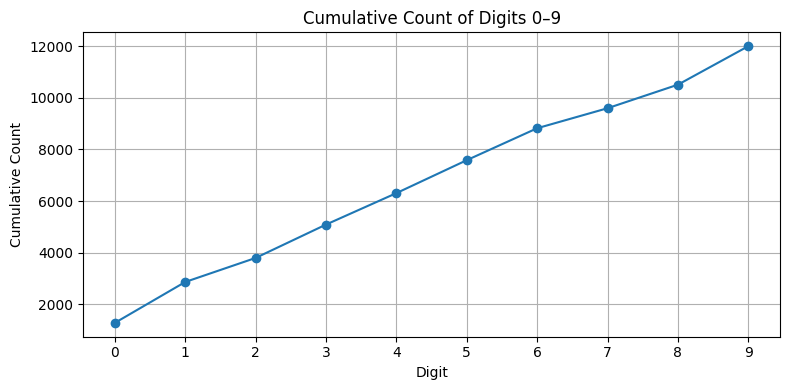

In [11]:
# ─── Cell 9: Cumulative Distribution Plot ─────────────────────────────────────
cum_counts = np.cumsum(counts)
plt.figure(figsize=(8,4))
plt.plot(digits, cum_counts, marker='o')
plt.xticks(digits)
plt.xlabel("Digit")
plt.ylabel("Cumulative Count")
plt.title("Cumulative Count of Digits 0–9")
plt.grid(True)
plt.tight_layout()
plt.show()

<div style="margin:0.5rem 0 1.5rem;padding:1rem;
            background:#fffbe6;border-left:4px solid #e2a400;
            font-family:Consolas,Menlo,monospace;">
  ✅ The cumulative plot shows a steadily increasing line from ~1200 at digit 0 up to ~12000 at digit 9,  
  confirming an even distribution across classes.
</div>

<!-- BLOCK 7.4: Sample Images by Predicted Class -->
<h3 style="font-size:1.4rem;margin-top:1.2rem;color:#333;">
  7.4 Example Images per Predicted Digit
</h3>
<p style="margin:0.5rem 0 1rem;padding:0.8rem;
          background:#eef5fb;border-left:4px solid #4a90e2;">
  Display up to 5 sample images for each predicted digit (0–9) to visually confirm model accuracy.
</p>

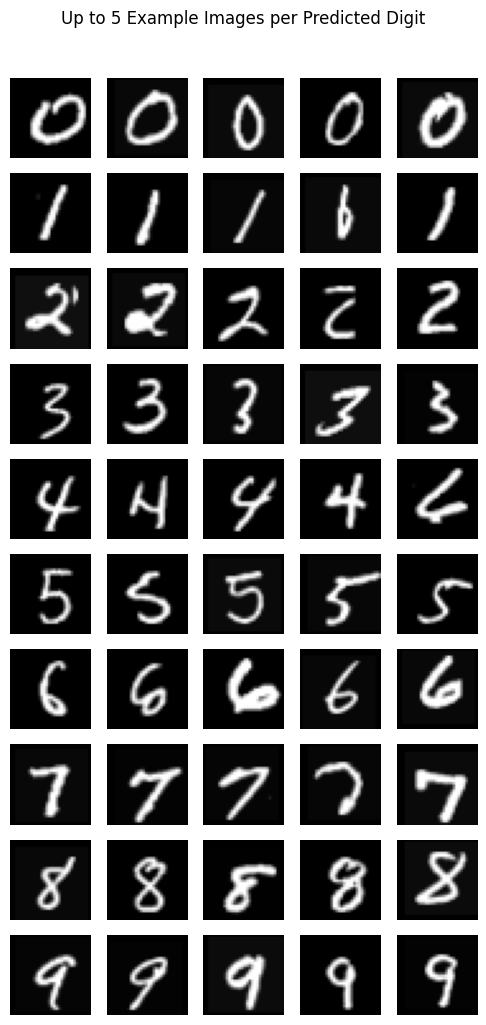

In [12]:
# ─── Cell 10: Sample Images by Predicted Class ─────────────────────────────────
import random
from PIL import Image
import math

# Build a dict of image paths per predicted digit
samples = {d: [] for d in digits}
for path in image_paths:
    # re-run a fast batch-pred approach, or if you stored `digits` from Cell 6:
    # 여기서는 당장 predictions re-compute one-by-one for sampling
    img = Image.open(path).convert('L').resize((28,28))
    arr = np.array(img).reshape(1,28,28,1).astype('float32') / 255.0
    d = int(np.argmax(model.predict(arr, verbose=0)))
    if len(samples[d]) < 5:
        samples[d].append(path)

# Plot a 10×5 grid of examples
fig, axes = plt.subplots(10, 5, figsize=(5,10))
for d in digits:
    for j in range(5):
        ax = axes[d][j]
        ax.axis('off')
        if j < len(samples[d]):
            img = Image.open(samples[d][j]).convert('L')
            ax.imshow(img, cmap='gray')
        if j == 0:
            ax.set_ylabel(str(d), rotation=0, labelpad=10, va='center')
plt.suptitle("Up to 5 Example Images per Predicted Digit", y=1.02)
plt.tight_layout()
plt.show()

<div style="margin:0.5rem 0 1.5rem;padding:1rem;
            background:#fffbe6;border-left:4px solid #e2a400;
            font-family:Consolas,Menlo,monospace;">
  ✅ Displays a 10×5 grid: each row labeled 0–9, showing up to five correct samples per digit.  
  This helps verify the model’s predictions visually.
</div>